In [2]:
import logging

import torch

import functools
import matplotlib.pyplot as plt
import numpy as np

# Disable future warnings.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Definition for left and right screws.
tetracubes = torch.tensor([
  # Right screw.
  [ [ -0.50,  0.25, -0.25 ], [ -0.50,  0.25,  0.75 ],
    [  0.50,  0.25, -0.25 ], [  0.50, -0.75, -0.25 ] ],
  # Left screw.
  [ [ -0.75,  0.50, -0.25 ], [  0.25, -0.50,  0.75 ],
    [  0.25,  0.50, -0.25 ], [  0.25, -0.50, -0.25 ] ],
])

In [4]:
def generate_datasets(num_train=1000, num_valid=100, noise_scale=0.05):

  # Assign a label to each tetracube.
  labels = torch.arange(tetracubes.shape[0])

  # Randomly choose among the 2 tetracubes to generate train and validation datasets.
  train_choice = torch.multinomial(torch.ones(tetracubes.shape[0]), num_samples=num_train, replacement=True)
  valid_choice = torch.multinomial(torch.ones(tetracubes.shape[0]), num_samples=num_valid, replacement=True)
  train_shapes = tetracubes[train_choice]
  valid_shapes = tetracubes[valid_choice]
 
  train_labels = labels[train_choice]
  valid_labels = labels[valid_choice]

  # Add Gaussian noise for some variety.
  train_shapes += noise_scale * torch.randn(train_shapes.shape)
  valid_shapes += noise_scale * torch.randn(valid_shapes.shape)

  # Return final train and validation datasets.
  train_data = dict(shapes=train_shapes, labels=train_labels)
  valid_data = dict(shapes=valid_shapes, labels=valid_labels)
  return train_data, valid_data

In [50]:
from typing import Callable, Optional, Protocol, Tuple, Union
import jaxtyping

Array = torch.Tensor
Float = jaxtyping.Float

def basis(
    r: torch.Tensor,
    max_degree: int,
    num: int,
    # radial_fn: Callable[[Float[Array, '...'], int], Float[Array, '... num']],
):
    r"""Basis function corresponding to e3x.nn.basis which uses
        e3nn.spherical_harmonics for angular functions
    """
    
    original_shape = r.shape[:-1]
    r = r.reshape(-1, 3)

    # Normalize input vectors.
    a = torch.maximum(torch.max(torch.abs(r)), torch.finfo(r.dtype).tiny)
    b = r / a
    norm = a * torch.sqrt(torch.sum(b * b, dim=-1, keepdim=True))
    u = r / torch.where(norm > 0, norm, 1)
    norm = norm.squeeze(-1)  # (...)

    # radial function
    # rbf = radial_fn(norm, num)  # (..., N)

    # basis function
    ylm = e3nn.spherical_harmonics(e3nn.s2_irreps(max_degree), u, normalize="component")
    return ylm
    
    product = lambda x, weight: lambda w: w * x(weight)(ylm, rbf)

    return product.reshape((*original_shape, *product.shape[-2:]))

In [ ]:
class TensorDense(torch.nn.Module):

    features: int
    max_degree: int
    irreps_out: e3nn.Irreps
    use_gaunt: bool

    @nn.compact
    def __call__(self, x: e3nn.IrrepsArray) -> e3nn.IrrepsArray:

        x1 = e3nn.o3.Linear(irreps_in=x.irreps, irreps_out=x.irreps, channel_out=self.features)(x)
        x2 = e3nn.o3.Linear(irreps_in=x.irreps, irreps_out=x.irreps, channel_out=self.features)(x)
            
        # Keep irreps only up to max_degree.
        filter_ir_out = e3nn.tensor_product(x1.irreps, x2.irreps).filter(
            lmax=self.max_degree
        )
    
        tp = 

        # Additionally, filter out irreps.
        irreps_out = self.irreps_out
        if irreps_out is None:
            irreps_out = tp.irreps

        x = e3nn.o3.Linear(irreps_in=tp.irreps_out, irreps_out=irreps_out)(tp)        
        return x

class E3NNModel(torch.nn.Module):
  features = 8
  max_degree = 3
  use_gaunt: bool = False

  def __call__(self, shapes):  # The 'shapes' array has shape (..., 4, 3).
      
    # 1. Center shapes at origin (for translational invariance).
    shapes -= torch.mean(shapes, keepdims=True, axis=-2)   # 'shapes' still has shape (..., 4, 3).
    
    # 2. Featurize by expanding cube midpoints in basis functions and taking the mean over the 4 cubes.
    
    x = basis( 
      shapes,
      num=self.features,
      max_degree=self.max_degree,
    #   radial_fn=functools.partial(e3x.nn.triangular_window, limit=2.0),
    ) # 'x' has shape (..., 4, (max_degree+1)**2, features).
    
    x = e3nn.mean(x, axis=-3)  # 'x' now has shape (..., (max_degree+1)**2, features).
        
    # 3. Apply feature transformations.
        
    "No pseudoscalar features yet"
    x = TensorDense(
            features=self.features, max_degree=self.max_degree, irreps_out=None, use_gaunt=self.use_gaunt
        )(x)
    
    "Pseduoscalar features in tensor product"
    x = TensorDense(
            features=self.features, max_degree=self.max_degree, irreps_out="0e + 0o", use_gaunt=self.use_gaunt
        )(x)

    x = x.axis_to_mul()
    # 4. Predict logits (with an ordinary Dense layer).
    logits = torch.nn.Linear(features=tetracubes.shape[0])(x.array)  # Logits has shape (..., 2).

    return logits

In [167]:
class OrdinaryModel(torch.nn.Module):
  features = 8
  
  def __init__(self):
      super().__init__()
      self.layers = torch.nn.Sequential(
          torch.nn.Linear(in_features=12, out_features=self.features), # 'x' has shape (..., features).
          torch.nn.ReLU(),
          torch.nn.Linear(in_features=self.features, out_features=self.features),
          torch.nn.ReLU(),
          torch.nn.Linear(in_features = self.features, out_features=tetracubes.shape[0]), # Logits has shape (..., 2).
      )
        
  def __call__(self, shapes):  # The 'shapes' array has shape (..., 4, 3).
    # 1. Center shapes at origin (for translational invariance).
    shapes -= torch.mean(shapes, keepdims=True, axis=-2)  # 'shapes' still has shape (..., 4, 3).

    # 2. Flatten xyz coordinates (input features).
    x = torch.reshape(shapes, (*shapes.shape[:-2], -1))  # 'x' has shape (..., 4*3).

    return self.layers(x)

In [208]:
def cross_entropy_loss(logits, labels):
    labels_onehot = torch.nn.functional.one_hot(labels, num_classes=tetracubes.shape[0])
    return torch.nn.functional.cross_entropy(input=logits, target=labels_onehot.float(), reduction="mean")

def compute_accuracy(logits, labels):
    return torch.mean((torch.argmax(logits, -1) == labels).float())

In [209]:
def train_step(model, criterion, optimizer, batch):
    logits = model(batch["shapes"])
    loss = criterion(logits, batch["labels"])
    # loss = cross_entropy_loss(logits, batch["labels"])
    loss.backward()
    optimizer.step()
    accuracy = compute_accuracy(logits, batch["labels"])
    return loss, accuracy


def eval_step(model, criterion, batch):
    logits = model(batch["shapes"])
    loss = criterion(logits, batch["labels"])
    accuracy = compute_accuracy(logits=logits, labels=batch["labels"])
    return loss, accuracy


def train_model(
    model, criterion, train_data, valid_data, num_epochs, learning_rate, batch_size
):
    # Initialize model parameters and optimizer state.
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Determine the number of training steps per epoch.
    train_size = len(train_data["shapes"])
    steps_per_epoch = train_size // batch_size

    # Train for 'num_epochs' epochs.
    for epoch in range(1, num_epochs + 1):
        # Draw random permutations for fetching batches from the train data.
        perms = torch.randperm(train_size)
        perms = perms[
            : steps_per_epoch * batch_size
        ]  # Skip the last batch (if incomplete).
        perms = perms.reshape((steps_per_epoch, batch_size))

        # Loop over all batches.
        train_loss = 0.0  # For keeping a running average of the loss.
        train_accuracy = 0.0  # For keeping a running average of the accuracy.
        for i, perm in enumerate(perms):
            batch = {k: v[perm, ...] for k, v in train_data.items()}
            if i == 0:
                print("batch", batch["shapes"].shape)
            loss, accuracy = train_step(
                model=model,
                criterion=criterion,
                optimizer=optimizer,
                batch=batch,
            )
            train_loss += (loss - train_loss) / (i + 1)
            train_accuracy += (accuracy - train_accuracy) / (i + 1)

        # Evaluate on the test set after each training epoch.
        valid_loss, valid_accuracy = eval_step(
            model=model, criterion=criterion, batch=valid_data
        )

        # Print progress.
        print(f"epoch: {epoch}")
        print(
            f"  train: loss {train_loss : 4.2f}, accuracy {train_accuracy * 100 : 6.2f}%"
        )
        print(
            f"  valid: loss {valid_loss : 4.2f}, accuracy {valid_accuracy * 100 : 6.2f}%"
        )

    # Return final model parameters.
    return model.parameters

In [210]:
# Generate train and test datasets.
train_data, valid_data = generate_datasets()

# Define training hyperparameters.
learning_rate = 0.005
num_epochs = 5
batch_size = 16

In [211]:
# Train the ordinary model.
ordinary_model = OrdinaryModel()
criterion = torch.nn.CrossEntropyLoss(reduction="mean")

ordinary_params = train_model(
    model=ordinary_model,
    criterion=criterion,
    train_data=train_data,
    valid_data=valid_data,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
)

batch torch.Size([16, 4, 3])
epoch: 1
  train: loss  0.49, accuracy  79.54%
  valid: loss  0.10, accuracy  100.00%
batch torch.Size([16, 4, 3])
epoch: 2
  train: loss  0.03, accuracy  99.60%
  valid: loss  0.00, accuracy  100.00%
batch torch.Size([16, 4, 3])
epoch: 3
  train: loss  0.05, accuracy  98.79%
  valid: loss  0.00, accuracy  100.00%
batch torch.Size([16, 4, 3])
epoch: 4
  train: loss  0.21, accuracy  97.58%
  valid: loss  0.05, accuracy  98.00%
batch torch.Size([16, 4, 3])
epoch: 5
  train: loss  0.00, accuracy  100.00%
  valid: loss  0.00, accuracy  100.00%


In [212]:
# copied from https://e3x.readthedocs.io/stable/_modules/e3x/so3/rotations.html#random_rotation

def random_rotation(
    perturbation: float = 1.0,
    num: int = 1,  # When num=1, leading dimension is automatically squeezed.
):
  r"""Samples a random :math:`3\times3` rotation matrix.

  Samples random :math:`3\times3` rotation matrices from :math:`\mathrm{SO(3)}`.
  The ``perturbation`` parameter controls how strongly random points on a sphere
  centered on the origin are perturbed by the rotation. For
  ``perturbation=1.0``, any point on the sphere is rotated to any other point on
  the sphere with equal probability. If ``perturbation<1.0``, returned rotation
  matrices are biased to identity matrices. For example, with
  ``perturbation=0.5``, a point on the sphere is rotated to any other point on
  the same hemisphere with equal probability.

  Example:
    >>> import jax
    >>> import e3x
    >>> e3x.so3.random_rotation(jax.random.PRNGKey(0), perturbation=1.0)
    Array([[-0.93064284, -0.11807037,  0.34635717],
           [ 0.33270139,  0.1210826 ,  0.9352266 ],
           [-0.15236041,  0.9855955 , -0.07340252]], dtype=float32)
    >>> e3x.so3.random_rotation(jax.random.PRNGKey(0), perturbation=0.0)
    Array([[1., 0., 0.],
           [0., 1., 0.],
           [0., 0., 1.]], dtype=float32)

  Args:
    key: A PRNG key used as the random key.
    perturbation: A value between 0.0 and 1.0 that determines the perturbation.
    num: Number of returned rotation matrices.

  Returns:
    An Array of shape :math:`(\mathrm{num}, 3, 3)` or :math:`(3, 3)` (if num =
    1) representing random :math:`3\times3` rotation matrices.
  """
  # Check that perturbation is a meaningful value.
  if not 0.0 <= perturbation <= 1.0:
    raise ValueError(
        f'perturbation must be between 0.0 and 1.0, received {perturbation}'
    )
  # Draw random numbers and transform them.
  twopi = 2 * np.pi
  u = torch.randn((num, 3))
  sqrt1 = torch.sqrt(1 - u[..., 0])
  sqrt2 = torch.sqrt(u[..., 0])
  angl1 = twopi * u[..., 1]
  angl2 = twopi * u[..., 2]
  # Construct random quaternion.
  r = sqrt1 * torch.sin(angl1)
  i = sqrt1 * torch.cos(angl1)
  j = sqrt2 * torch.sin(angl2)
  k = sqrt2 * torch.cos(angl2)
  # Perturbation (Slerp starting from identity quaternion).
  flip = r < 0  # Flip sign if r < 0 (always take the shorter route).
  r = torch.where(flip, -r, r)
  i = torch.where(flip, -i, i)
  j = torch.where(flip, -j, j)
  k = torch.where(flip, -k, k)
  phi = torch.arccos(r)
  sinphi = torch.sin(phi)
  # Prevent division by zero.
  zeromask = torch.abs(sinphi) < 1e-9
  f1 = torch.where(
      zeromask, 1 - perturbation, np.sin((1 - perturbation) * phi) / sinphi
  )
  f2 = torch.where(zeromask, perturbation, np.sin(perturbation * phi) / sinphi)
  r, i, j, k = f1 + f2 * r, f2 * i, f2 * j, f2 * k
  # Construct rotation matrix.
  i2, j2, k2 = i * i, j * j, k * k
  ij, ik, jk, ir, jr, kr = i * j, i * k, j * k, i * r, j * r, k * r
  row1 = torch.stack((1 - 2 * (j2 + k2), 2 * (ij - kr), 2 * (ik + jr)), axis=-1)
  row2 = torch.stack((2 * (ij + kr), 1 - 2 * (i2 + k2), 2 * (jk - ir)), axis=-1)
  row3 = torch.stack((2 * (ik - jr), 2 * (jk + ir), 1 - 2 * (i2 + j2)), axis=-1)
  rot = torch.squeeze(torch.stack((row1, row2, row3), axis=-1))
  return rot

In [213]:
# Determine the accuracy of the equivariant and ordinary models for rotated shapes with different
# perturbation magnitudes (a perturbation of 0.0 gives identity matrices, a perturbation of 1.0 gives
# fully random rotation matrices).
perturbations = np.linspace(0.0, 1.0, num=6)
ordinary_accuracy = np.zeros(len(perturbations))

for i, perturbation in enumerate(perturbations):
  rot = random_rotation(perturbation=perturbation, num=len(valid_data['shapes']))
  rotated_shapes = torch.vmap(lambda x, r: x@r)(valid_data['shapes'], rot)
  rotated_valid_data = {'shapes': rotated_shapes, 'labels': valid_data['labels']}
#   _, equivariant_accuracy[i] = eval_step(equivariant_model.apply, rotated_valid_data, equivariant_params)
  _, ordinary_accuracy[i] = eval_step(ordinary_model, criterion, rotated_valid_data)
#   _, e3nn_accuracy[i] = eval_step(e3nn_model.apply, rotated_valid_data, e3nn_params)
#   _, gtp_accuracy[i] = eval_step(gtp_model.apply, rotated_valid_data, gtp_params)

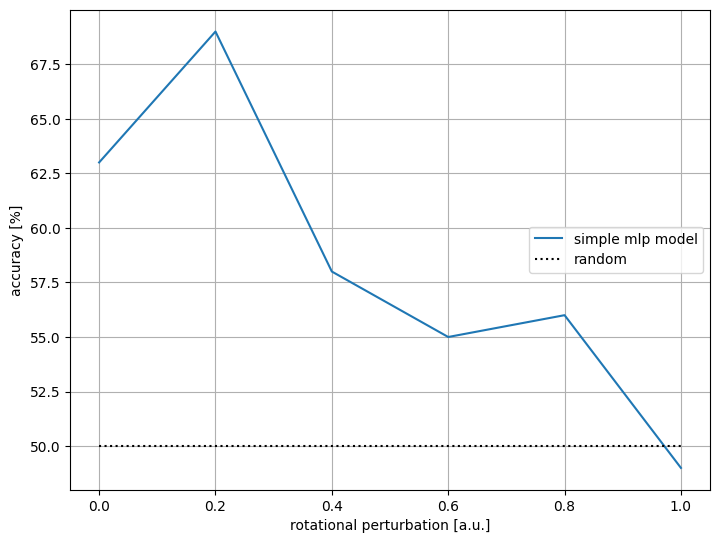

In [214]:
# Plot the results.
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('rotational perturbation [a.u.]')
plt.ylabel('accuracy [%]')
plt.plot(perturbations, ordinary_accuracy * 100, label='simple mlp model')
plt.hlines(y=100/tetracubes.shape[0], xmin=0.0, xmax=1.0, color='k', ls=':', label='random')
plt.legend(loc='center right')
plt.grid()